In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras_tuner as kt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping
from scipy.fft import fft



In [22]:
# Loading the datasets
accelerometer_data = pd.read_csv('/home/mzero/main/uni_repo/machine_learning_fqs_2024/ml4qs-gesture-recognition/data/preprocced_data/Combined_accelerometer_80min.csv')
gyroscope_data = pd.read_csv('/home/mzero/main/uni_repo/machine_learning_fqs_2024/ml4qs-gesture-recognition/data/preprocced_data/Combined_gyroscope_80min.csv')
linear_accelerometer_data = pd.read_csv('/home/mzero/main/uni_repo/machine_learning_fqs_2024/ml4qs-gesture-recognition/data/preprocced_data/Combined_linear_accelerometer_80min.csv')
magnetometer_data = pd.read_csv('/home/mzero/main/uni_repo/machine_learning_fqs_2024/ml4qs-gesture-recognition/data/preprocced_data/Combined_magnetometer_80min.csv')

### Transformation

In [23]:
# Merge datasets on time and label columns - syncronizing to same time point.
df = pd.merge(accelerometer_data, gyroscope_data, on=['time', 'label'])
df = pd.merge(df, linear_accelerometer_data, on=['time', 'label'])
df = pd.merge(df, magnetometer_data, on=['time', 'label'])

In [24]:
display(df)

,time,X (m/s^2)_x,Y (m/s^2)_x,Z (m/s^2)_x,label,X (rad/s),Y (rad/s),Z (rad/s),X (m/s^2)_y,Y (m/s^2)_y,Z (m/s^2)_y,X (µT),Y (µT),Z (µT)
0,0.0,9.986539,-0.004582,0.850397,handshake,-0.351920,-0.527611,0.563546,0.985623,-0.431386,1.030669,-38.050217,-30.089358,-12.836142
1,0.5,5.105301,-0.415617,0.850397,handshake,0.100001,-0.372286,-0.199083,-3.393721,-4.024062,-0.465686,-29.666510,-39.405896,-4.669382
2,1.0,8.871006,-2.852091,0.976863,handshake,0.392478,0.032676,-0.380796,0.328653,-6.355668,0.483817,-27.597006,-38.219096,-4.700792
3,1.5,8.871006,-5.486469,1.202958,handshake,0.049560,-0.169104,-0.362988,0.968687,-6.555062,-0.033927,-25.183688,-39.710181,-8.059941
4,2.0,9.990088,-5.486469,1.151986,handshake,0.057486,0.206438,-0.281776,1.509423,-7.636509,-0.098818,-30.950762,-32.967047,-9.577583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9555,4778.5,-2.424369,5.592076,-4.316893,waving,-0.017034,0.178253,-0.059087,1.895874,-2.766447,-1.512145,19.415402,-37.545494,10.890142
9556,4779.0,-4.087585,4.795250,-3.674595,waving,0.153044,-0.171879,0.268310,1.172432,0.134634,-0.083616,18.625039,-38.041110,11.736007
9557,4779.5,-4.173743,4.213670,-4.552890,waving,0.007826,0.395523,-0.597318,2.564878,-1.729809,-0.560276,15.610884,-41.993545,9.435524
9558,4780.0,-2.880119,5.454926,-3.751154,waving,0.018189,0.051757,-0.648156,0.917136,-4.558381,-0.906490,21.293894,-36.012943,8.505168


##### Fourier Transformation --> Normalization Method: X

###### Fourier Transform

In [25]:

# Applying Fast Fourier Transformation - Discrete fourier Transformation
def apply_dft(df):
    features_X = df.columns.difference(['time', 'label'])
    df[features_X] = np.abs(fft(df[features_X], axis=1))
    return df 

data = apply_dft(df)    

###### Normalization

In [26]:
# Normalize the feature columns
features_X = data.columns.difference(['time', 'label'])
scaler = StandardScaler()
data[features_X] = scaler.fit_transform(data[features_X])

# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

In [27]:
# Verify the unique classes
print(f"Classes: {label_encoder.classes_}")
print(f"Number of classes: {label_encoder.classes_.shape[0]}")

Classes: ['clapping' 'handshake' 'highfive' 'waving']
Number of classes: 4


##### Normalization -> Fourier Transformation Method: Y

###### Normalization

In [28]:
# # Normalize the feature columns
# features = data.columns.difference(['time', 'label'])
# scaler = StandardScaler()
# data[features] = scaler.fit_transform(data[features])

# # Encode labels
# label_encoder = LabelEncoder()
# data['label'] = label_encoder.fit_transform(data['label'])

###### Fourier Transform

In [29]:

# # Applying Fast Fourier Transformation - Discrete fourier Transformation
# def apply_dft(df):
#     features = df.columns.difference(['time', 'label'])
#     df[features] = np.abs(fft(df[features], axis=1))
#     return df 

# data = apply_dft(df)    

# print(data)

### Long Short-term Memory Model Implimentation

###### Create a Sequence

In [30]:
# Reshape the data - DOCUMENTED AS THE WAY TO PASS DATA TO THE LSTM NEEDS TO BE A SEQUENCE to learn the temporal patterns matching sequence to label 
time_steps = 50  # Number of time steps to look back for predictions - RANDOMLY CHOSEN NO RATIONAL YET
X = []
y = []
# Create sequences of data

for i in range(time_steps, len(data)):
    X.append(data.iloc[i-time_steps:i][features_X].values)  # Use past values only, without the label
    y.append(data.iloc[i]['label'])  # Predict the current label

X, y = np.array(X), np.array(y)

###### Data Splitting

In [31]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

###### LSTM Model - Tenserflow & Keras

In [32]:
# Hyperparameter Optimisation 
# Define Builder 
def model_builder(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=16), 
                   input_shape=(X_train.shape[1], X_train.shape[2])))# Tuning the number of units in the first LSTM layer
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1))) # Tuning the dropout rate
    model.add(Dense(units=4, activation='softmax'))  # Output layer
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy']) # Compile the model
    
    return model

In [33]:
# Instantiate the tuner and perform hypertuning
# Using Hyperband strategy of performance eleimination
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='/home/mzero/main/uni_repo/machine_learning_fqs_2024/ml4qs-gesture-recognition/results/tuner',
    project_name='ml4qs_gesture_recognition'
)


2024-06-15 17:41:20.017668: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-15 17:41:20.018002: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/mzero/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
# stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) # Creating a early stop when ther eis no longer gain
tuner.search(X_train, y_train, epochs=50, validation_split=0.3, callbacks=[EarlyStopping(monitor='val_loss', patience=5)) # Search for the best parameters 
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]# Get the optimal hyperparameters

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 74 Complete [00h 00m 24s]
val_accuracy: 0.999499499797821

Best val_accuracy So Far: 0.999499499797821
Total elapsed time: 00h 17m 34s

Search: Running Trial #75

Value             |Best Value So Far |Hyperparameter
80                |80                |units
0.4               |0                 |dropout
0.00042477        |0.0095512         |learning_rate
17                |17                |tuner/epochs
0                 |6                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/17
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4398 - loss: 1.1703 - val_accuracy: 0.7192 - val_loss: 0.6905
Epoch 2/17
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7797 - loss: 0.6023 - val_accuracy: 0.8814 - val_loss: 0.3928
Epoch 3/17
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8810 - loss: 0.3889 - val_accuracy: 0.9094 - val_loss: 0.3075
Epoch 4/17
  1/146 ━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.3)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

### Validation

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9958 - loss: 0.0118
Test Accuracy: 0.9972


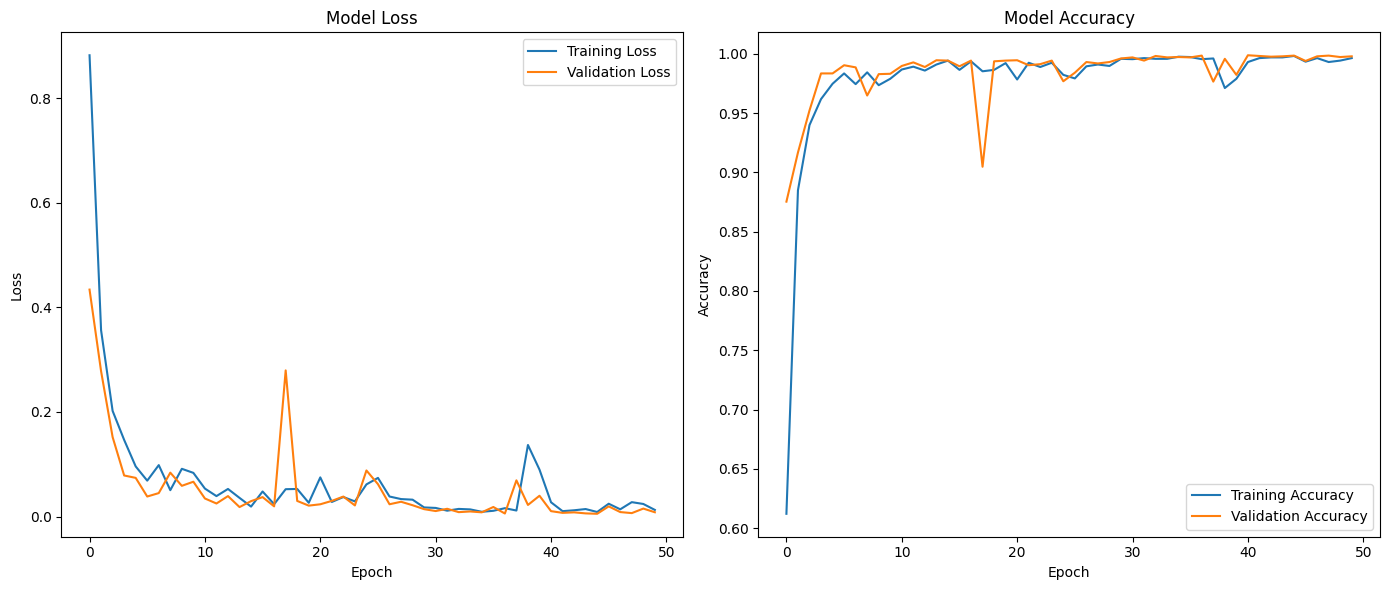

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9958 - loss: 0.0118
Test Loss: 0.0084
Test Accuracy: 0.9972


In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

######  F1 Score Metrics

In [ ]:
# Assuming you have already split the data into X_train, X_test, y_train, y_test
# and have trained the model

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [ ]:
# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Calculate and print F1 score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f'Weighted Precision: {precision:.4f}')
print(f'Weighted Recall: {recall:.4f}')
print(f'Weighted F1 Score: {f1:.4f}')


              precision    recall  f1-score   support

    clapping       1.00      1.00      1.00       736
   handshake       1.00      1.00      1.00       715
    highfive       1.00      1.00      1.00       685
      waving       1.00      1.00      1.00       717

    accuracy                           1.00      2853
   macro avg       1.00      1.00      1.00      2853
weighted avg       1.00      1.00      1.00      2853

Weighted Precision: 0.9972
Weighted Recall: 0.9972
Weighted F1 Score: 0.9972
